# Interior Design


## Get data

In [0]:
!pip install wget

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
#mount google drive in case we need to store data or transfer files

from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [0]:
# copy if you want any pretrained models or export
import os
#os.mkdir('data/')
! cp "/content/drive/My Drive/Colab Notebooks/dataset_dropped.csv" "/content/data/data.csv"

## Get the data

In [0]:
from pathlib import Path
path = Path('data/')

In [0]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv(path/'data.csv')
df.head()

,links,labels
0,https://s3.amazonaws.com/havenly-uploads/prod/...,Classic
1,https://s3.amazonaws.com/havenly-uploads/prod/...,Modern
2,https://s3.amazonaws.com/havenly-uploads/prod/...,Modern
3,https://s3.amazonaws.com/havenly-uploads/prod/...,Farmhouse
4,https://s3.amazonaws.com/havenly-uploads/prod/...,Coastal


Unique classes: Modern               3121
Classic              2709
Eclectic             2342
Bohemian              969
Glam                  548
Farmhouse             491
Coastal               453
Industrial            393
Traditional           212
Midcentury Modern     156
Scandinavian          124
Transitional          108
Rustic                106
Global                 57
Minimal                50
Preppy                  9
Name: labels, dtype: int64


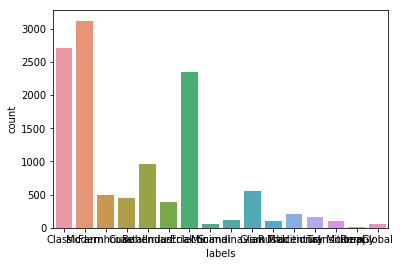

In [0]:
print ('Unique classes:', df['labels'].value_counts())
sns.countplot(x='labels', data=df)

In [0]:
# create subset of dataset where each label has at least 50 images
new_df = df[df['labels'] != 'Preppy']
new_df = new_df[new_df['labels'] != 'Minimal']
new_df = new_df[new_df['labels'] != 'Global']
print (new_df.shape, df.shape)

(11732, 2) (11848, 2)


In [0]:
drop_links = df[df.links.str.contains('^https://havenly.com/img/icon/no-image.png')]

In [0]:
# drop the empty images links
new_df = new_df.drop(drop_links.index)
new_df.shape

(11720, 2)

In [0]:
lbls = new_df['labels'].unique()
lbls

array(['Classic', 'Modern', 'Farmhouse', 'Coastal', 'Bohemian', 'Industrial', 'Eclectic', 'Scandinavian', 'Glam',
       'Rustic', 'Traditional', 'Midcentury Modern', 'Transitional'], dtype=object)

In [0]:
rnd_index = []
dfs = []
for l in lbls:
    rnd_df = new_df[new_df['labels']==l]
    #rnd_index = random.sample(list(indexes), 50)
    dfs.append(rnd_df[:100].values)

In [0]:
dfs = np.array(dfs)
dfs = dfs.reshape(1300, 2)

In [0]:
final_df = pd.DataFrame(dfs, columns=['links', 'labels'])
final_df.head()

,links,labels
0,https://s3.amazonaws.com/havenly-uploads/prod/...,Classic
1,https://s3.amazonaws.com/havenly-uploads/prod/...,Classic
2,https://s3.amazonaws.com/havenly-uploads/prod/...,Classic
3,https://s3.amazonaws.com/havenly-uploads/prod/...,Classic
4,https://s3.amazonaws.com/havenly-uploads/prod/...,Classic


In [0]:
final_df.shape

(1300, 2)

Unique classes: Scandinavian         100
Eclectic             100
Traditional          100
Glam                 100
Coastal              100
Farmhouse            100
Midcentury Modern    100
Classic              100
Industrial           100
Rustic               100
Bohemian             100
Modern               100
Transitional         100
Name: labels, dtype: int64


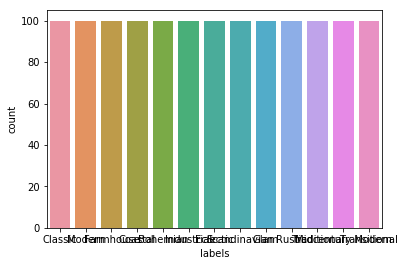

In [0]:
print ('Unique classes:', final_df['labels'].value_counts())
sns.countplot(x='labels', data=final_df)

In [0]:
os.mkdir('data/train_images')

In [0]:
import wget
from tqdm import tqdm

def download_images():
    for i in tqdm(range(len(final_df))):
        url = final_df['links'].iloc[i]
        wget.download(url, '/content/data/train_images/img'+str(i)+'.jpg')

In [0]:
download_images()

100%|██████████| 1300/1300 [36:30<00:00,  1.60s/it]


In [0]:
links_name = ['img'+str(i)+'.jpg' for i in range(len(final_df))]

In [0]:
very_final_df = pd.DataFrame(columns=['fn', 'class'])
very_final_df['fn'] = links_name
very_final_df['class'] = final_df['labels']
very_final_df.head()

,fn,class
0,img0.jpg,Classic
1,img1.jpg,Classic
2,img2.jpg,Classic
3,img3.jpg,Classic
4,img4.jpg,Classic


In [0]:
very_final_df.to_csv('/content/data/annots.csv', index=False)

## EDA

In [0]:
import pandas as pd
import numpy as np
import random
from pathlib import Path
path = Path('data/train_images')

In [0]:
train_df = pd.read_csv('/content/data/annots.csv')
train_df.head()

,fn,class
0,img0.jpg,Classic
1,img1.jpg,Classic
2,img2.jpg,Classic
3,img3.jpg,Classic
4,img4.jpg,Classic


In [0]:
import matplotlib.pyplot as plt
import random
import imageio
%matplotlib inline

def show_images(img_path, path, classes, rows=2, columns=4):
    fig=plt.figure(figsize=(18, 9))
    for i in range(1, columns*rows+1):
        img = imageio.imread(path/img_path[i-1])    
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(f'size: {img.shape}, class : {classes[i-1]}')
        plt.axis('off')

In [0]:
rnd = random.sample(list(np.arange(len(train_df))), 8)
df = train_df.iloc[rnd]
files = df['fn'].values
classes = df['class'].values

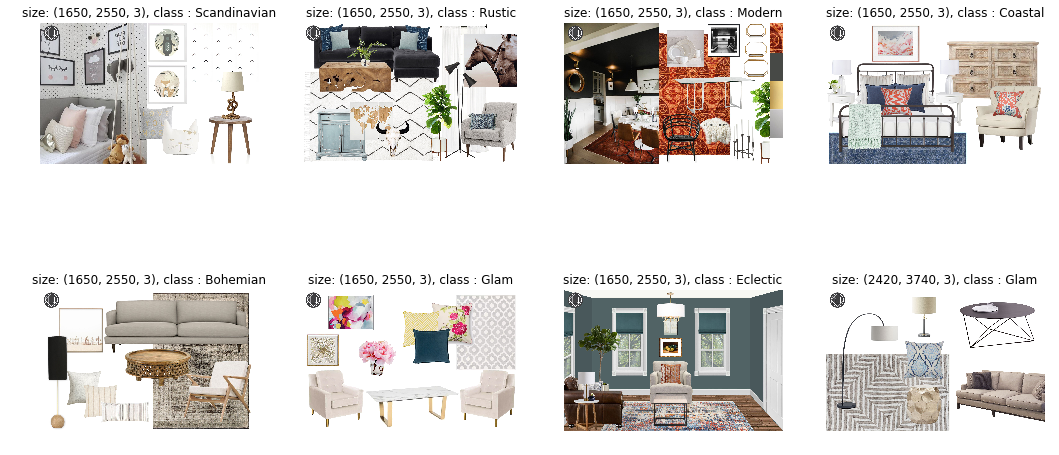

In [0]:
show_images(files, path, classes)

## Fastai

In [0]:
# import required fastai libraries

from fastai.vision import *
import numpy as np
import os

In [0]:
# path to dataset
path = Path('data/').resolve()

In [0]:
# we will apply transformations such as lightining, zoom, changing brightness and
# changing contrast and resizing it to size 224 which is required for resnet50

tfms = get_transforms(do_flip=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.2,
                      xtra_tfms=[brightness(change=(0.5*(1-0.1), 0.5*(1+0.1)), p=0.75),
                                 contrast(scale=(1-0.1, 1/(1-0.1)), p=0.75)])

# batch size
bs = 64

In [0]:
# fastai datablock where we split data into 20% validation and 80% training

src = (ImageList.from_df(train_df, path, folder='train_images') #define source of input
       .split_by_rand_pct(0.2)       #ratio of split
       .label_from_df())           #grab the labels from name of folders

In [0]:
# create databunch

data = (src.transform(tfms, size=224)  #resize images to 224
        .databunch(bs=bs)              #batch size=64
        .normalize(imagenet_stats))    #normalize data using imagenet mean, std

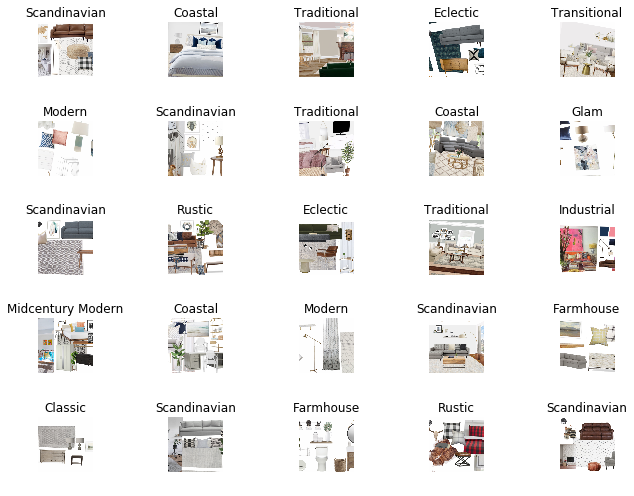

In [0]:
# show me sample images from dataset

data.show_batch(rows=5, figsize=(9, 7))

In [0]:
# print all the classes and number of classes
print(data.classes)
len(data.classes)

['Bohemian', 'Classic', 'Coastal', 'Eclectic', 'Farmhouse', 'Glam', 'Industrial', 'Midcentury Modern', 'Modern', 'Rustic', 'Scandinavian', 'Traditional', 'Transitional']


13

## Model

In [0]:
# create a resnet50 architecture with metrics like top-1 accuracy and top-5 accuracy

learn = create_cnn(data, models.resnet50, metrics=[error_rate, accuracy, top_k_accuracy])
learn.model

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 22668326.11it/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


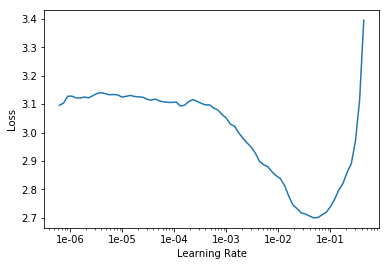

In [0]:
# Step 1: freeze and find learning rate, in this case we choose lr=1e-2

learn.lr_find()
learn.recorder.plot()

In [0]:
# using Cycle policy in super-convergence method, we fit using lr
# obtained from above result for 5 epochs

lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,2.921838,2.822247,0.769231,0.230769,0.596154,02:40
1,2.499161,2.601447,0.750000,0.250000,0.611538,02:38
2,2.173643,2.486363,0.753846,0.246154,0.623077,02:36
3,1.877886,2.385589,0.696154,0.303846,0.642308,02:35
4,1.671985,2.367011,0.696154,0.303846,0.653846,02:35


In [0]:
# save the trained model if you don't wan't to redo everything again!

learn.save('/content/224_stage-1')

In [0]:
# create a backup by copying the saved model to google drive! 
# precaution is better than no caution!

%time !cp "/content/224_stage-1.pth" "/content/drive/My Drive/Colab Notebooks/224_stage-1.pth"

CPU times: user 26.2 ms, sys: 39.2 ms, total: 65.4 ms
Wall time: 2.63 s


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


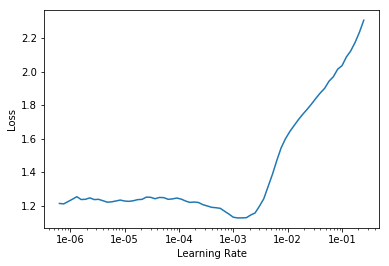

In [0]:
# Step 2: unfreeze and train

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# using cycle policy in super-convergence method we train for 4 epochs

learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.262602,2.339336,0.684615,0.315385,0.653846,02:36
1,1.179824,2.279171,0.688462,0.311538,0.676923,02:35
2,1.053083,2.291899,0.642308,0.357692,0.696154,02:35
3,0.897187,2.420646,0.638462,0.361538,0.676923,02:35
4,0.750439,2.524082,0.630769,0.369231,0.703846,02:34
5,0.622716,2.635329,0.646154,0.353846,0.684615,02:37
6,0.506725,2.748109,0.626923,0.373077,0.680769,02:36
7,0.412004,2.733493,0.619231,0.380769,0.661538,02:35
8,0.336323,2.701825,0.626923,0.373077,0.673077,02:34
9,0.276116,2.670599,0.611538,0.388462,0.673077,02:36


In [0]:
# save the trained model if you don't wan't to redo everything again!

learn.save('/content/224_stage-2')

In [0]:
# create a backup by copying the saved model to google drive! 
# precaution is better than no caution!

%time !cp "/content/224_stage-2.pth" "/content/drive/My Drive/Colab Notebooks/224_stage-2.pth"

CPU times: user 24.3 ms, sys: 45.7 ms, total: 69.9 ms
Wall time: 2.95 s


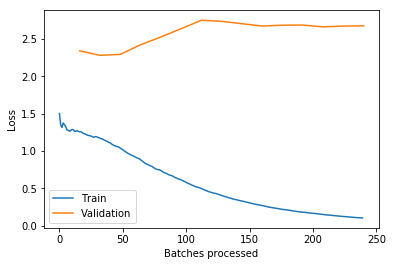

In [0]:
# plot the losses as we can see there is lot of noise in train
# that is due to training on mini-batches and it follows the
# expected trend of train loss less than validation loss 

learn.recorder.plot_losses()

In [0]:
# we reduce the batch size as the size of images will be larger
# change the size from 224 to 512 and load the data in our trained model
bs = bs // 4

data = (src.transform(tfms, size=512)
        .databunch(bs=bs).normalize(imagenet_stats))

learn.data = data

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


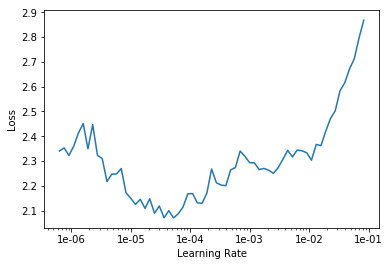

In [0]:
# Step 3: Freeze andYes, with train on 512 size images
# We again follow the same lr find method and obtain lr = 3.98E-06

learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# train model for 2 epochs it takes longer time to run than previous
# we don't want our work and time to count for nothing
# better to break 4 epochs into 2 save model and train for 2 again

learn.fit_one_cycle(7, slice(1e-05))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,2.242777,3.071190,0.730769,0.269231,0.730769,04:22
1,2.473991,3.262353,0.726923,0.273077,0.684615,04:19
2,2.294193,3.088229,0.742308,0.257692,0.688462,04:19
3,2.170226,3.092859,0.726923,0.273077,0.703846,04:15
4,2.067247,3.151573,0.730769,0.269231,0.692308,04:14
5,2.105034,3.126516,0.719231,0.280769,0.700000,04:15
6,2.067809,3.146438,0.742308,0.257692,0.700000,04:14


In [0]:
# save model

learn.save('/content/512_stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


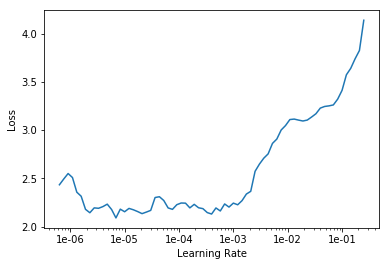

In [0]:
# Step 4: Unfreeze and train

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# finally last 3 epochs to complete the training procedure

lr = 1e-5
learn.fit_one_cycle(7, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,2.587456,3.167707,0.726923,0.273077,0.707692,04:19
1,2.287240,3.072059,0.726923,0.273077,0.711538,04:22
2,2.271147,2.957868,0.734615,0.265385,0.700000,04:17
3,2.074641,2.989335,0.738462,0.261538,0.703846,04:22
4,2.312314,3.213593,0.738462,0.261538,0.688462,04:22
5,2.008348,3.116051,0.711538,0.288462,0.719231,04:17
6,1.976815,3.084428,0.715385,0.284615,0.676923,04:20


In [0]:
# save model in case we need it for inference

learn.save('/content/512_stage-2')

In [0]:
# we reduce the batch size as the size of images will be larger
# change the size from 224 to 512 and load the data in our trained model

bs = bs // 8

data = (src.transform(tfms, size=1024)
        .databunch(bs=bs).normalize(imagenet_stats))

learn.data = data

In [0]:
# Step 3: Freeze and train on 512 size images
# We again follow the same lr find method and obtain lr = 3.98E-06

learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# train model for 2 epochs it takes longer time to run than previous
# we don't want our work and time to count for nothing
# better to break 4 epochs into 2 save model and train for 2 again

lr = 1e-3
learn.fit_one_cycle(7, slice(lr))

In [0]:
# save model

learn.save('/content/1024_stage-2')

In [0]:
# Step 4: Unfreeze and train

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# finally last 3 epochs to complete the training procedure

lr = 1e-3
learn.fit_one_cycle(7, slice(1e-6, lr/5))

In [0]:
# save model in case we need it for inference

learn.save('/content/1024_stage-2')

In [0]:
c

In [0]:
4# as always take precaution by creating a copy

%time !cp "/content/1024_stage-2.pth" "/content/drive/My Drive/Colab Notebooks/1024_stage-2.pth"

In [0]:
# wow, look at the curves

learn.recorder.plot_losses()

In [0]:
# fancy method in fastai to export all the classes and model architecture
# to file 'export.pkl'

learn.export()

In [0]:
# create a copy of that too!

%time !cp {path}"/export.pkl" "/content/drive/My Drive/Colab Notebooks/export.pkl"

In [0]:
# load export.pkl by specifying the path where export.pkl is located

learn = load_learner(Path("/content/"))

## Interplotion

In [0]:
# yay! show me what you learned
# tta is fancy method called test time augmentation

interp = ClassificationInterpretation.from_learner(learn, tta=True)

losses,idxs = interp.top_losses()

In [0]:
# ahh, the heatmaps!
# we say: tell me where were you looking at to make such prediction
# model replies: I was looking in these areas

interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# how is the confusion in the confusion matrix?

interp.plot_confusion_matrix(figsize=(30, 30), dpi=60)

In [0]:
# where was the model more prone to make mistakes?
# which two classes are creating confusing more and more?

interp.most_confused(min_val=2)